# Project Predictive Analytics: New York City Taxi Ride Duration Prediction

## **Marks: 40**
---------------

## **Context**
---------------

New York City taxi rides form the core of the traffic in the city of New York. The many rides taken every day by New Yorkers in the busy city can give us a great idea of traffic times, road blockages, and so on.

A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is hassle-free. One of the main issues is predicting the duration of the current ride so it can predict when the cab will be free for the next trip.

Here, the data set contains various pointers regarding the taxi trips and their duration in New York City. 

We will apply an array of techniques to get insights into the data and determine how different variables are dependent on the Trip Duration.

-----------------
## **Objective**
-----------------

- To Build a predictive model, for predicting the duration for the taxi ride. 
- Use Automated feature engineering to create new features

-----------------
## **Dataset**
-----------------

The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``vendor_id`` is the taxi cab company - in our case study we have data from three different cab companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff 
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 
  - 1= Credit card
  - 2= Cash 3= No charge
  - 4= Dispute
  - 5= Unknown
  - 6= Voided
* ``trip_duration`` this is the duration (in seconds) we would like to predict using other fields 
* ``pickup_neighborhood`` a one or two letter id of the neighborhood where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighborhood where the trip ended



## We will do the following steps:
  * Install the dependencies
  * Load the data as a pandas dataframe
  * Perform EDA on the dataset
  * Build features with Deep Feature Synthesis using the [featuretools](https://featuretools.com) package. We will start with simple features and incrementally improve the feature definitions while examining the accuracy of the system.

> Uncomment the code given below, and run the line of code to install featuretools library

In [1]:
# Uncomment the code given below, and run the line of code to install featuretools library

# !pip install featuretools==0.27.0

> Note: If !pip install featuretools doesn't work, please install using the anaconda prompt by typing the following command in anaconda prompt
> 
>  `conda install -c conda-forge featuretools==0.27.0`

## Importing libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Feataurestools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0


In [3]:
# set global random seed
np.random.seed(40)

# To load the dataset
def load_nyc_taxi_data():
    trips = pd.read_csv('./data/trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv("./data/pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv("./data/dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods

### To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]



#to compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


#to generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



#to see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

## Load the Datasets

In [4]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
649598,679634,1,2016-04-30 11:45:59,2016-04-30 11:47:47,1,0.50,-73.994919,40.755226,-74.000351,40.747917,1,108.0,D,AG
649599,679635,2,2016-04-30 11:46:04,2016-04-30 11:47:41,2,0.33,-73.978935,40.777172,-73.981888,40.773136,2,97.0,AV,AV
649600,679636,2,2016-04-30 11:46:39,2016-04-30 11:58:02,1,1.78,-73.998207,40.745201,-73.990265,40.729023,2,683.0,AP,H
649601,679637,2,2016-04-30 11:46:44,2016-04-30 11:55:42,1,1.40,-73.987129,40.739429,-74.007370,40.743511,2,538.0,R,Q
649602,679638,2,2016-04-30 11:47:30,2016-04-30 11:54:00,1,1.12,-73.942375,40.790768,-73.952095,40.777145,2,390.0,J,AM
649603,679639,1,2016-04-30 11:47:38,2016-04-30 11:57:22,2,1.90,-73.960800,40.769920,-73.978966,40.785698,1,584.0,K,I
649604,679640,1,2016-04-30 11:47:49,2016-04-30 12:01:05,1,4.30,-74.013885,40.709515,-73.987213,40.722343,2,796.0,AU,AC
649605,679641,1,2016-04-30 11:48:17,2016-04-30 12:01:02,1,2.90,-73.975426,40.757584,-73.999016,40.722027,1,765.0,A,X
649606,679642,1,2016-04-30 11:49:44,2016-04-30 12:00:03,1,1.30,-73.989815,40.750454,-74.000473,40.762352,2,619.0,D,P


## Display first five rows

In [5]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2016-01-01 00:20:45,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1076.0,AG,AV


## Display info of the dataset

In [6]:
#checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974409 entries, 0 to 974408
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    974409 non-null  int64         
 1   vendor_id             974409 non-null  category      
 2   pickup_datetime       974409 non-null  datetime64[ns]
 3   dropoff_datetime      974409 non-null  datetime64[ns]
 4   passenger_count       974409 non-null  int64         
 5   trip_distance         974409 non-null  float64       
 6   pickup_longitude      974409 non-null  float64       
 7   pickup_latitude       974409 non-null  float64       
 8   dropoff_longitude     974409 non-null  float64       
 9   dropoff_latitude      974409 non-null  float64       
 10  payment_type          974409 non-null  object        
 11  trip_duration         974409 non-null  float64       
 12  pickup_neighborhood   974409 non-null  object        
 13 

- There are `974409` non-null values in the dataset
- The data-types are as expected

In [7]:
def missing_check(df):
    total = df.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data # return the dataframe
missing_check(trips)

,Total,Percent
id,0,0.0
vendor_id,0,0.0
pickup_datetime,0,0.0
dropoff_datetime,0,0.0
passenger_count,0,0.0
trip_distance,0,0.0
pickup_longitude,0,0.0
pickup_latitude,0,0.0
dropoff_longitude,0,0.0
dropoff_latitude,0,0.0


## Check the number of unique values in the dataset.

In [8]:
# Check the uniques values in each columns
trips.nunique()

id                      974409
vendor_id                    2
pickup_datetime         939015
dropoff_datetime        938873
passenger_count              8
trip_distance             2503
pickup_longitude         20222
pickup_latitude          40692
dropoff_longitude        26127
dropoff_latitude         50077
payment_type                 4
trip_duration             3607
pickup_neighborhood         49
dropoff_neighborhood        49
dtype: int64

**Write your answers here:**
- `vendor_id` has only 2 unique values, implies there are only 2 major taxi vendors in the dataset. 
- `passenger_count` has 8 unique values and `payment_type` have 4. 
- There are 49 neighborhoods in the dataset, from where either a pickup or dropoff is happening. 

## Question 1 : Check summary statistics of the dataset (1 Mark)

In [9]:
#chekcing the descriptive stats of the data
round(trips.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
id,974409.0,509622.259,294491.647,0.00,254521.000,509310.000,764743.000,1020002.000
passenger_count,974409.0,1.664,1.315,0.00,1.000,1.000,2.000,9.000
trip_distance,974409.0,2.734,3.307,0.00,1.000,1.640,2.990,502.800
pickup_longitude,974409.0,-73.973,0.036,-74.03,-73.991,-73.981,-73.967,-73.771
pickup_latitude,974409.0,40.752,0.027,40.63,40.740,40.755,40.769,40.850
dropoff_longitude,974409.0,-73.973,0.031,-74.03,-73.990,-73.979,-73.963,-73.770
dropoff_latitude,974409.0,40.753,0.029,40.63,40.739,40.756,40.770,40.850
trip_duration,974409.0,797.703,576.802,0.00,389.000,646.000,1040.000,3606.000


**Write your answers here:**
- The `median` and `75%` of the `passenger_count` is 1 and  2 respectively. 
- Average `trip_distance` is **2.73km**, with a maximum value of **502km** and minimum of **0**.
- Average `trip_duration` is **797 sec**. 

### Checking for the rows for which `trip_distance` is `0`

In [10]:
#Chekcing the rows where trip distance is 0
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,2016-01-01 02:16:17,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,2016-01-01 03:03:26,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,2016-01-01 04:10:48,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,2016-01-01 04:16:57,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,2016-01-01 04:36:16,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972967,1018490,1,2016-06-30 19:09:44,2016-06-30 19:22:21,1,0.0,-73.945480,40.751400,-73.945496,40.751549,2,757.0,AN,AN
973384,1018928,2,2016-06-30 20:35:08,2016-06-30 20:35:10,1,0.0,-73.983864,40.693813,-73.983910,40.693817,1,2.0,AS,AS
973555,1019105,2,2016-06-30 21:13:50,2016-06-30 21:14:05,1,0.0,-74.008789,40.708740,-74.008659,40.708858,1,15.0,AU,AU
973607,1019159,2,2016-06-30 21:24:23,2016-06-30 21:37:40,1,0.0,-73.974510,40.778297,-73.977272,40.754047,1,797.0,I,AD


In [11]:
noTripDistance=trips[trips['trip_distance']==0].shape[0]
print("We can observe we have", noTripDistance, "rows where `trip_distance` is `0`.")

We can observe we have 3807 rows where `trip_distance` is `0`.


**Write your answers here:**
- We can observe we have `3807` rows where `trip_distance` is `0`.

### Checking for the rows for which `trip_duration` is `0`

In [12]:
noTripDuration=trips[trips['trip_duration']==0].shape[0]
print("We can observe we have", noTripDuration, "rows where `trip_duration` is `0`.")

We can observe we have 25 rows where `trip_duration` is `0`.


**Write your answers here:**
- We can observe we have `25` rows where `trip_duration` is `0`.

#### Dropping the `0` values in `trip_distance` and `trip_duration`

In [13]:
missingRows = noTripDistance+noTripDuration
totalRows = trips.shape[0]
missingRowsPercentage = (missingRows*100)/totalRows

print("The dataset has", missingRows, "`0` values,",
      "representing the", round(missingRowsPercentage,3),"% of the whole dataset")

The dataset has 3832 `0` values, representing the 0.393 % of the whole dataset


- Given that we have `3832` rows with a value of `0` in features where it does not make sense to have `0` values, and our dataset is `974409` rows long. we will asume **there were missing valus which were replaced with `0` and we will drop the `0` values instead of imputing them to keep our predictions as accurate as possible.** Note that we are only loosing `~0.393%` of the dataset.

In [14]:
trips['trip_distance'].replace(0, np.nan, inplace=True)
trips['trip_duration'].replace(0, np.nan, inplace=True)
missing_check(trips)

,Total,Percent
trip_distance,3807,0.003907
trip_duration,25,0.000026
id,0,0.000000
vendor_id,0,0.000000
pickup_datetime,0,0.000000
dropoff_datetime,0,0.000000
passenger_count,0,0.000000
pickup_longitude,0,0.000000
pickup_latitude,0,0.000000
dropoff_longitude,0,0.000000


- With the new considerations, we can observe that we have filtered out `~0.393%` of our data. This will marginally reduce the sample size, but will increase the accuracy of our predictions.

In [15]:
trips = trips.dropna()
missing_check(trips)

,Total,Percent
id,0,0.0
vendor_id,0,0.0
pickup_datetime,0,0.0
dropoff_datetime,0,0.0
passenger_count,0,0.0
trip_distance,0,0.0
pickup_longitude,0,0.0
pickup_latitude,0,0.0
dropoff_longitude,0,0.0
dropoff_latitude,0,0.0


## Question 2: Univariate Analysis

### Question 2.1: Build histogram for numerical columns (1 Marks)

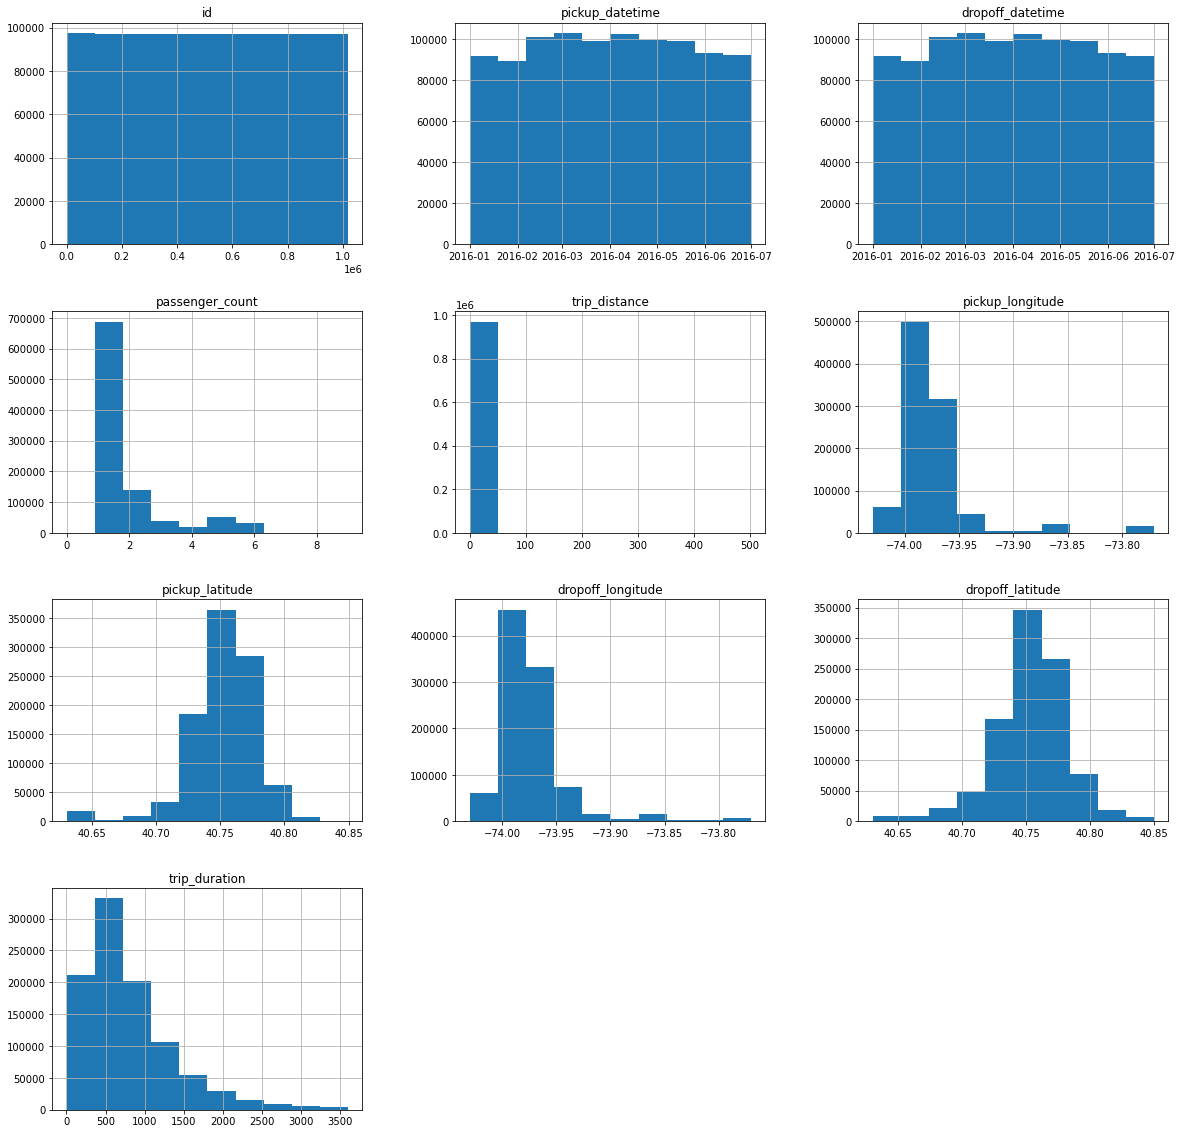

In [16]:
trips.hist(figsize=(20,20))
plt.show()

**Write your answers here:**
- Recall that *``id`` is just a trip identifier*, so it is **irrelevant** for this question.
- ``pickup_datetime`` follows a nearly **unitary distribution**. This suggests there is basically the **same demand for taxi rides year round**.
- `dropoff_datetime` is the same plot as `pickup_datetime`, this is to be expected since *it is not possible to start a ride and never finish it*.
- `passenger_count` is **right skewed**. This suggests that **most taxy rides in NYC are for one or two passengers**. Note that the graph goes up to eight passengers. This means that we have at least one >8 passenger ride in our dataset, and we may have to remove it to clean up our results.
- ``trip_distance`` seem to have some outlier values since we only see a bar at the zero value, we can investigate this further plotting a boxplot. 
- ``pickup_latitude`` and  ``dropoff_latitude`` follow a nearly **normal distribution**, while  ``pickup_longitude`` and ``dropoff_longitude``  are a bit **right skewed**.
- ``trip_duration`` is **right skewed**. *Recall the vaues for this variable are in seconds*. The graph suggests **most trips are ~500 seconds long (~8 min.).**

#### Clipping the outliers of `passenger_count` to 6

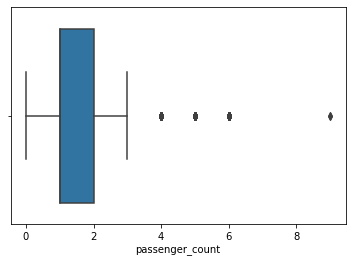

In [17]:
sns.boxplot(trips['passenger_count'])
plt.show()

In [18]:
trips[trips['passenger_count']>6]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
757983,793284,1,2016-05-19 21:24:55,2016-05-19 22:04:15,9,18.70,-73.787331,40.641785,-73.950508,40.809975,1,2360.0,G,AL
905094,947306,2,2016-06-17 09:15:22,2016-06-17 09:15:33,9,0.01,-73.987236,40.693108,-73.987343,40.693306,1,11.0,AS,AS


- We observe 2 outliers with 9 passengers per ride. Since we are predicting ride duration, we can clip these values without affecting our predictions.

In [19]:
trips['passenger_count']=trips['passenger_count'].clip(trips['passenger_count'].min(),6)

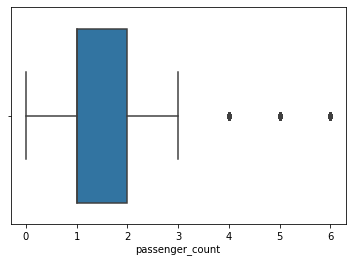

In [20]:
sns.boxplot(trips['passenger_count'])
plt.show()

***

#### Clipping the outliers of `trip_distance` to 50

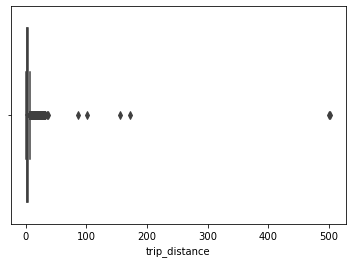

In [21]:
sns.boxplot(trips['trip_distance'])
plt.show()

- We observe an extreme outlier in the dataset, we drop it and investigate further

In [22]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
171143,178815,1,2016-02-04 14:05:10,2016-02-04 14:56:37,1,156.2,-73.979149,40.765499,-73.782806,40.644009,1,3087.0,AR,G
248346,259490,1,2016-02-18 09:48:06,2016-02-18 09:50:27,1,501.4,-73.980087,40.782185,-73.981468,40.778519,2,141.0,I,AV
525084,548884,1,2016-04-07 21:19:03,2016-04-07 22:03:17,3,172.3,-73.783340,40.644176,-73.936028,40.737762,2,2654.0,G,AN
530340,554389,1,2016-04-08 19:19:32,2016-04-08 19:41:33,2,502.8,-73.995461,40.724884,-73.986099,40.762108,1,1321.0,X,AA
828650,867217,1,2016-06-02 21:30:17,2016-06-02 21:36:47,2,101.0,-73.961586,40.800968,-73.950165,40.802193,2,390.0,AH,J


- We can observe that, there are 2 observations >500, and there is a huge gap in the `trip_duration` for them.
- Covering 501.4 distance in 141 sec, is not possible, it is better we can clip these values to 50. 

In [23]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)

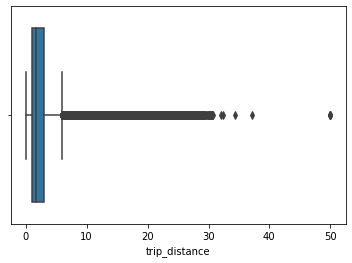

In [24]:
sns.boxplot(trips['trip_distance'])
plt.show()

### Question 2.2 Plotting countplot for Passenger_count (1 Marks)

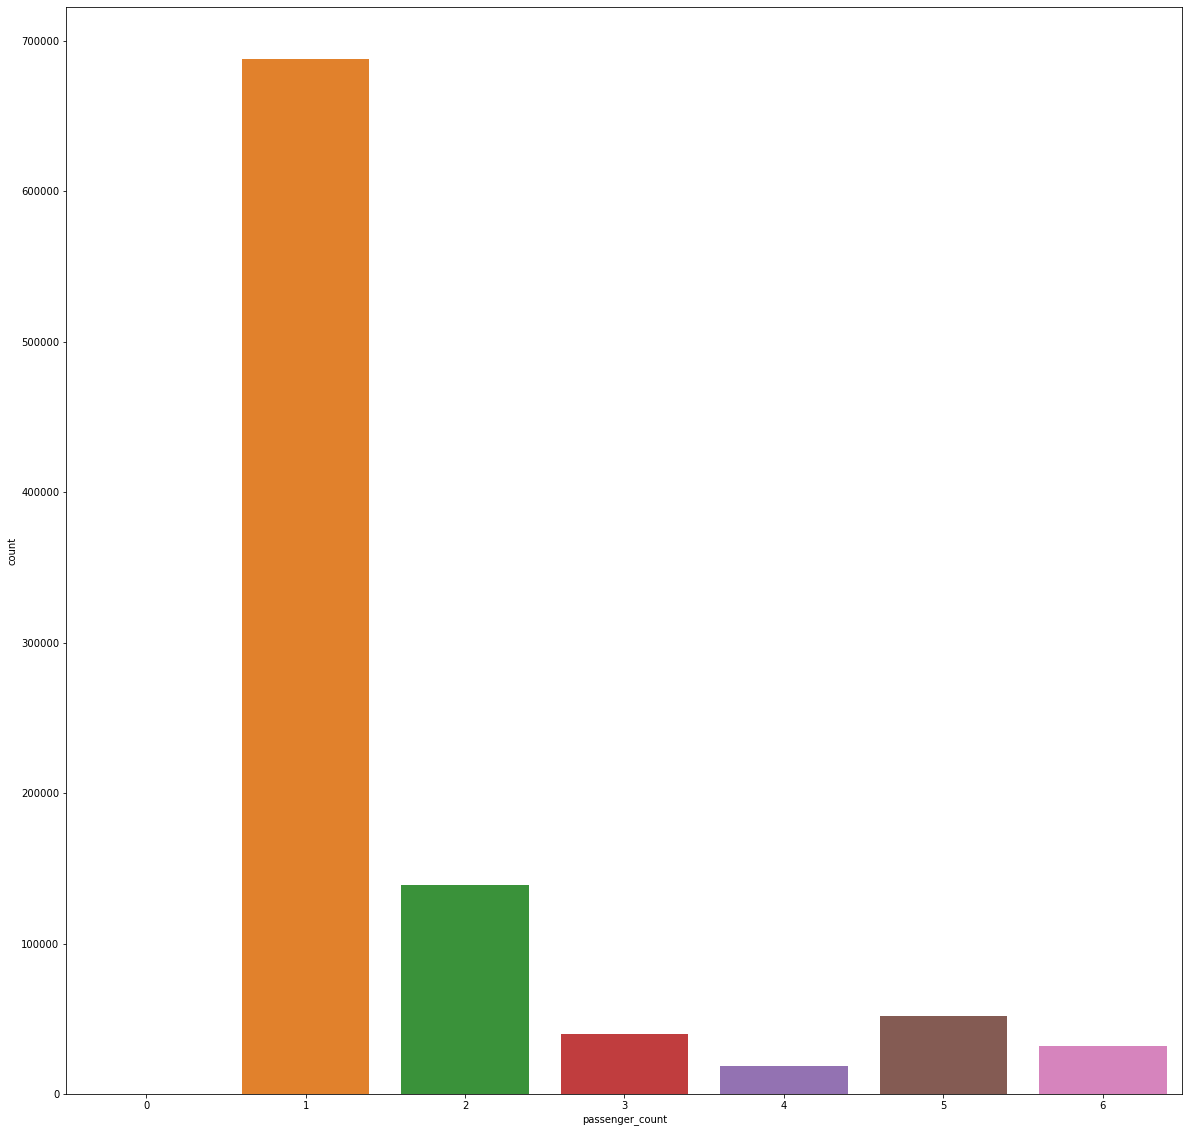

In [25]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.countplot(trips.passenger_count)
plt.show()

In [26]:
trips.passenger_count.value_counts(normalize=True)

1    0.708863
2    0.143620
5    0.053524
3    0.041210
6    0.033414
4    0.019357
0    0.000011
Name: passenger_count, dtype: float64

**Write your answers here:**
- The plot above suggests most trips are for one passenger.

### Question 2.3 Plotting countplot for pickup_neighborhood and dropoff_neighborhood (2 Marks)

<AxesSubplot:>

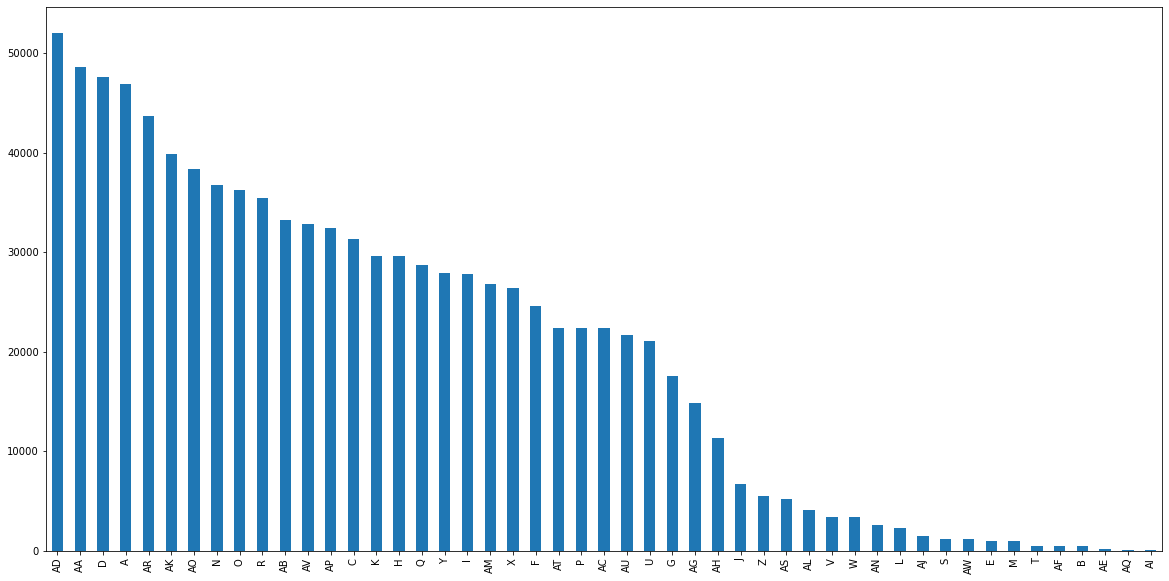

In [27]:
trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,10))

<AxesSubplot:>

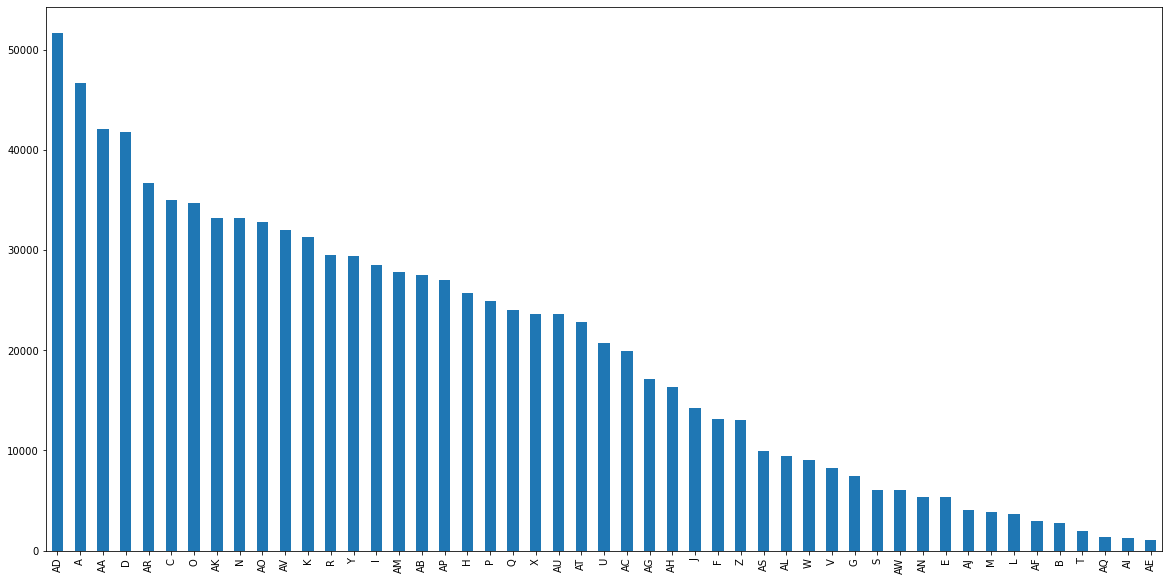

In [28]:
trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,10))

**Write your answers here:**
- Most of the ``pickup_neighborhood`` and ``dropoff_neighborhood`` values are from area AD,A,AA and D; this may suggest these are are the most busy areas in the city. 
- Areas like AQ,AI and AE are some areas from where very few number of pickups and dropoff are happening. 

### Bivariate analysis

#### Plot a scatter plot for trip distance and trip duration

<AxesSubplot:xlabel='trip_distance', ylabel='trip_duration'>

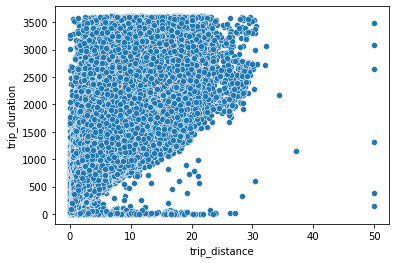

In [29]:
sns.scatterplot(trips['trip_distance'],trips['trip_duration'])

- There is some positive correlation between `trip_distance` and `trip_duration`. This is to be expected. However, note that the plot shows pretty much all possible combinations of `trip_duration` and `trip_distance`. At first glance this may suggest ther is not a strong correlation between the two variables; however, this behavior may be due to the fact that we are not taking traffic into account, if we did, the correlation may be clearer.

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

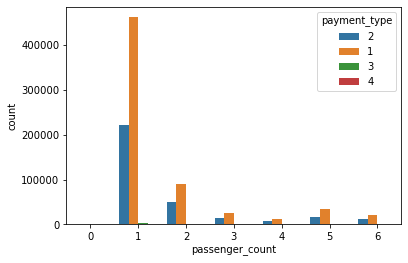

In [30]:
sns.countplot(trips['passenger_count'],hue=trips['payment_type'])

- Recall that the `payment_type` code is:
  - 1= Credit card 
  - 2= Cash 
  - 3= No charge 
  - 4= Dispute 
  - 5= Unknown 
  - 6= Voided
- The plot suggests that pretty much all trips are payed either in cash or card. 
- We expect to see close to no `payment_type` values with the codes 3,4,5 or 6 since they represent extremely rare situations.

### Step 2: Prepare the Data

Lets create entities and relationships. The three entities in this data are 
* `trips` 
* `pickup_neighborhoods`
* `dropoff_neighborhoods`

This data has the following relationships
* `pickup_neighborhoods` --> `trips` (one neighborhood can have multiple `trips` that start in it. This means `pickup_neighborhoods` is the ``parent_entity`` and `trips` is the child entity)
* `dropoff_neighborhoods` --> `trips` (one neighborhood can have multiple `trips` that end in it. This means `dropoff_neighborhoods` is the ``parent_entity`` and `trips` is the child entity)

In <a href="https://www.featuretools.com/">featuretools (automated feature engineering software package)</a>, we specify the list of entities and relationships as follows: 


### Question 3: Define entities and relationships for the Deep Feature Synthesis (2 Marks)

In [31]:
entities = {
            "trips": (trips, "id", 'pickup_datetime' ),
            "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
            "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
            }

relationships = [
                ("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")
                ]

Next, we specify the `cutoff_time` for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

**For the purposes of the case study, we choose to only select trips that started after January 12th, 2016.**

In [32]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)

,id,pickup_datetime
54031,56311,2016-01-12 00:00:25
667496,698305,2016-05-03 17:36:52
667497,698306,2016-05-03 17:36:56
667498,698307,2016-05-03 17:37:01
667499,698309,2016-05-03 17:37:11
667500,698310,2016-05-03 17:37:34
667501,698311,2016-05-03 17:37:45
667502,698312,2016-05-03 17:37:56
667503,698313,2016-05-03 17:38:03
667504,698314,2016-05-03 17:38:12


### Step 3: Create baseline features using Deep Feature Synthesis

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

**Create transform features using transform primitives**

As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featuretools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

### Question 4: Creating a baseline model with only 1 transform primitive (10 Marks)

**Question: 4.1 Define transform primitive for weekend and define features using dfs?** 

In [33]:
trans_primitives = [IsWeekend]

#Remove _________ and complete the code
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

*If you're interested about parameters to DFS such as `ignore_variables`, you can learn more about these parameters [here](https://docs.featuretools.com/generated/featuretools.dfs.html#featuretools.dfs)*
<p>Here are the features created.</p>

In [34]:
print ("Number of features: %d" % len(features))
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]


Now let's compute the features. 

### Question: 4.2 Compute features and define feature matrix

In [35]:
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                cutoff_time=cutoff_time,
                                                approximate='36d',
                                                verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [36]:
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:05 | Progress: 100%|██████████
Finishing computing...


In [37]:
preview(feature_matrix1, 5).T

id,56311,698305,698306,698307,698309
trip_duration,645.0,837.0,133.0,919.0,434.0
payment_type,1,1,2,2,1
passenger_count,1,1,1,1,1
pickup_neighborhood = AD,False,False,False,False,False
pickup_neighborhood = AA,False,True,True,False,False
pickup_neighborhood = D,False,False,False,False,False
pickup_neighborhood = A,False,False,False,False,False
pickup_neighborhood = AR,False,False,False,False,False
pickup_neighborhood = AK,False,False,False,False,False
pickup_neighborhood = AO,False,False,False,False,False


In [38]:
feature_matrix1.shape

(916765, 31)

### Build the Model

To build a model, we
* Separate the data into a portion for ``training`` (75% in this case) and a portion for ``testing`` 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a `Linear Regression, Decision Tree `and` Random Forest model`

#### Transforming the duration variable on sqrt and log

(array([  1961.,  35086., 163693., 249450., 225270., 149512.,  80443.,
         38469.,  18048.,   8652.]),
 array([ 1.        ,  6.90499792, 12.80999584, 18.71499376, 24.61999167,
        30.52498959, 36.42998751, 42.33498543, 48.23998335, 54.14498127,
        60.04997918]),
 <BarContainer object of 10 artists>)

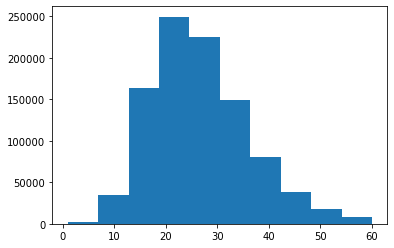

In [39]:
plt.hist(np.sqrt(trips['trip_duration']))

(array([8.00000e+01, 1.69000e+02, 2.06000e+02, 5.15000e+02, 2.06000e+03,
        1.95530e+04, 1.35559e+05, 3.69553e+05, 3.50708e+05, 9.21810e+04]),
 array([0.        , 0.81903544, 1.63807088, 2.45710632, 3.27614176,
        4.0951772 , 4.91421264, 5.73324808, 6.55228352, 7.37131896,
        8.1903544 ]),
 <BarContainer object of 10 artists>)

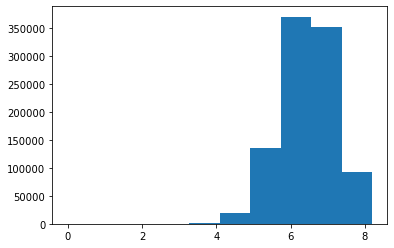

In [40]:
plt.hist(np.log(trips['trip_duration']))

- We can clearly see that the sqrt transformation is giving nearly normal distribution, there for we can choose the sqrt transformation on the dependent(`trip_duration`) variable.

### Splitting the data into train and test

In [41]:
# separates the whole feature matrix into train data feature matrix, 
# train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

### Defining function for to check the performance of the model. 

In [42]:
#RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test, naming):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    performanceTable = pd.DataFrame(
                                    {
                                      naming: ["Train", "Test"],
                                      'RSquared':
                                          [round(r2_score(y_observed_train,y_pred_train),3),
                                          round(r2_score(y_observed_test,y_pred_test),3)
                                          ],
                                      "RMSE": [
                                          round(rmse(y_pred_train, y_observed_train),3),
                                          round(rmse(y_pred_test, y_observed_test),3),
                                      ],
                                      "MAE": [
                                          round(mae(y_pred_train, y_observed_train),3),
                                          round(mae(y_pred_test, y_observed_test),3),
                                      ],
                                    }
                                  )
    performanceTable.name = naming
    return(performanceTable);

#### Question 4.3 Build Linear regression using only weekend transform primitive

In [43]:
#defining the model

lr1=LinearRegression()

#fitting the model
lr1.fit(X_train,y_train)


LinearRegression()

#### Check the performance of the model

In [44]:
lr1Performance = model_pref(lr1, X_train, X_test,y_train,y_test,'lr1')

lr1Performance

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


**Write your answers here:**
- Model is giving only `~0.56` $\mathrm{R}^2$, with RMSE of `~6.48` and MAE of `~4.98`.
- Model is slightly overfitting.

#### Question 4.4 Building decision tree using only weekend transform primitive

In [45]:
#define the model
dt=DecisionTreeRegressor()

#fit the model

dt.fit(X_train,y_train)

DecisionTreeRegressor()

#### Check the performance of the model

In [46]:
dt1Performance = model_pref(dt, X_train, X_test,y_train,y_test,'dt1')

display(dt1Performance)

,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


**Write your answers here:**
- The model is overfitting a lot, with train $\mathrm{R}^2$ of `~0.92` while test $\mathrm{R}^2$ is `~0.59`
- This generally happens in decision trees, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves. 


#### Question 4.5 Building Pruned decision tree using only weekend transform primitive

In [47]:
#define the model

#use max_depth=7
dt_pruned=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [48]:
dt1_pPerformance = model_pref(dt_pruned, X_train, X_test,y_train,y_test, 'dt1_p')

display(lr1Performance, dt1Performance, dt1_pPerformance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


**Write your answers here:**
- The pruned model is performing better than both baseline decision tree(`dt1`) and linear regression(`lr1`), with $\mathrm{R}^2$ of `~0.70`.


#### Question 4.6 Building Random Forest using only weekend transform primitive

In [49]:
#define the model

#using (n_estimators=60,max_depth=7)

rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [50]:
#fit the model

rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [51]:
rf1Performance = model_pref(rf, X_train, X_test,y_train,y_test, 'rf1')

display(lr1Performance, dt1Performance, dt1_pPerformance, rf1Performance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


,rf1,RSquared,RMSE,MAE
0,Train,0.739,4.773,3.644
1,Test,0.709,5.269,3.987


**Write your answers here:**
- The score for the model with only 1 transform primitive is `~71%`. 
- This model is performing marginally better than the pruned decision tree model(`dt1_p`).

### Step 4: Adding more Transform Primitives and creating new model

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

### Question 5: Create models with more transform primitives (10 Marks)

**Question 5.1 Define more transform primitives and define features using dfs?**

In [52]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [53]:
print ("Number of features: %d" % len(features))
features

Number of features: 23


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Now let's compute the features. 

**Question: 5.2 Compute features and define feature matrix**

In [54]:
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:06 | Progress: 100%|██████████
Finishing computing...


In [55]:
feature_matrix2.shape

(916765, 41)

In [56]:
feature_matrix2.head().T

id,56311,56312,56313,56314,56315
dropoff_neighborhoods.longitude,-73.998366,-73.954298,-73.948046,-73.977943,-73.948046
MINUTE(dropoff_datetime),11,23,5,6,13
vendor_id,2,2,1,2,2
payment_type,1,2,1,2,1
MONTH(dropoff_datetime),1,1,1,1,1
DAY(dropoff_datetime),12,12,12,12,12
trip_duration,645.0,1270.0,207.0,214.0,570.0
trip_distance,1.61,16.15,0.8,1.33,2.35
passenger_count,1,1,1,5,1
IS_WEEKEND(pickup_datetime),False,False,False,False,False


### Build the new models more transform features

In [57]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

#### Question 5.3 Building Linear regression using more transform primitive

In [58]:
#defining the model

lr2=LinearRegression()

#fitting the model
lr2.fit(X_train2,y_train2)


LinearRegression()

#### Check the performance of the model

In [59]:
lr2Performance = model_pref(lr2, X_train2, X_test2,y_train2,y_test2, 'lr2')

display(lr1Performance, lr2Performance, 
        dt1Performance, 
        dt1_pPerformance, 
        rf1Performance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,lr2,RSquared,RMSE,MAE
0,Train,0.627,5.713,4.246
1,Test,0.627,5.966,4.508


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


,rf1,RSquared,RMSE,MAE
0,Train,0.739,4.773,3.644
1,Test,0.709,5.269,3.987


**Write your answers here:**
- The model(`lr2`) is giving `~0.62` $\mathrm{R}^2$, with RMSE of `~6.04` and MAE of `~4.54`.
- The model performance has worsened compared to the last model(`rf1`) by adding more transform primitives, but improved compared to its predecessor(`lr1`)
- The model is not overfitting, thus giving generalized results.

#### Question 5.4 Building Decision tree using more transform primitive

In [60]:
#define the model
dt2=DecisionTreeRegressor()

#fit the model

dt2.fit(X_train2,y_train2)

DecisionTreeRegressor()

#### Check the performance of the model

In [61]:
dt2Performance = model_pref(dt2, X_train2, X_test2,y_train2,y_test2, 'dt2')

display(lr1Performance, lr2Performance,
        dt1Performance, dt2Performance,
        dt1_pPerformance,
        rf1Performance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,lr2,RSquared,RMSE,MAE
0,Train,0.627,5.713,4.246
1,Test,0.627,5.966,4.508


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt2,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.000
1,Test,0.718,5.189,3.742


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


,rf1,RSquared,RMSE,MAE
0,Train,0.739,4.773,3.644
1,Test,0.709,5.269,3.987


**Write your answers here:**
- The model(`dt2`) is overfitting a lot, with train $\mathrm{R}^2$ of `1` while test $\mathrm{R}^2$ is `~0.72`.
- As stated before, this usually happens with decision trees, one solution for this is to Prune the decision tree, let's prune and see if the performance improves.

#### Question 5.5 Building Pruned Decision tree using more transform primitive

In [62]:
#define the model

#use max_depth=7
dt_pruned2=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned2.fit(X_train2,y_train2)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [63]:
dt2_pPerformance = model_pref(dt_pruned2, X_train2, X_test2,y_train2,y_test2, 'dt2_p')

display(lr1Performance, lr2Performance,
        dt1Performance, dt2Performance,
        dt1_pPerformance, dt2_pPerformance,
        rf1Performance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,lr2,RSquared,RMSE,MAE
0,Train,0.627,5.713,4.246
1,Test,0.627,5.966,4.508


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt2,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.000
1,Test,0.718,5.189,3.742


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


,dt2_p,RSquared,RMSE,MAE
0,Train,0.773,4.459,3.366
1,Test,0.751,4.872,3.627


,rf1,RSquared,RMSE,MAE
0,Train,0.739,4.773,3.644
1,Test,0.709,5.269,3.987


**Write your answers here:**
- Model(`dt2_p`) is giving $\mathrm{R}^2$ of `~0.75`, with RSME of `~4.96` and MAE of `~3.70`.
- Model performance has improved over `dt2` by adding more transform features, and **is currently the best performing of the bunch**.
- Model is slightly overfitting.

#### Question 5.6 Building Random Forest using more transform primitive

In [64]:
#fit the model

#using (n_estimators=60,max_depth=7)

rf2=RandomForestRegressor(n_estimators=60,max_depth=7)

#fit the model

rf2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [65]:
rf2Performance = model_pref(rf2, X_train2, X_test2,y_train2,y_test2, 'rf2')

display(lr1Performance, lr2Performance,
        dt1Performance, dt2Performance,
        dt1_pPerformance, dt2_pPerformance,
        rf1Performance, rf2Performance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,lr2,RSquared,RMSE,MAE
0,Train,0.627,5.713,4.246
1,Test,0.627,5.966,4.508


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt2,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.000
1,Test,0.718,5.189,3.742


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


,dt2_p,RSquared,RMSE,MAE
0,Train,0.773,4.459,3.366
1,Test,0.751,4.872,3.627


,rf1,RSquared,RMSE,MAE
0,Train,0.739,4.773,3.644
1,Test,0.709,5.269,3.987


,rf2,RSquared,RMSE,MAE
0,Train,0.778,4.403,3.317
1,Test,0.756,4.820,3.581


**Write your answers here:**
- The score for this model(`rf2`) with more transform primitive is `~75%`. 
- When compared to its predecesor(`rf1`), the score has improved, as well as when compared to the previous model(`dt2_p`)
- **This is currently the best performing model of the bunch**.

### Question 5.7: Comment on how the modeling accuracy differs when including more transform features.

**Write your answers here:**
- When buiding our models with mode transform feature (with the current parameters), we observe an increase in performance across the board. This inidcates that including more transfom features makes a big improvement and it was worth testing.

### Step 5: Add Aggregation Primitives

Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the `trips` entity, which is the entity for which we are trying to make predictions.

### Question 6: Create models with transform and aggregate primitive. (10 Marks)
#### 6.1 Define more transform and aggregate primitive and define features using dfs

In [66]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [67]:
print ("Number of features: %d" % len(features))
features

Number of features: 61


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature:

#### Question: 6.2 Compute features and define feature matrix

In [68]:
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:14 | Progress: 100%|██████████
Finishing computing...


In [69]:
feature_matrix3.head().T

id,56311,56312,56313,56314,56315
dropoff_neighborhoods.MAX(trips.passenger_count),6,6,6,6,6
dropoff_neighborhoods.SUM(trips.trip_distance),3380.99,3649.84,2489.35,3609.21,2489.35
dropoff_neighborhoods.STD(trips.passenger_count),1.305519,1.338534,1.285643,1.376742,1.285643
pickup_neighborhoods.MEDIAN(trips.trip_distance),2.475,17.52,1.8,1.6,1.6
WEEKDAY(pickup_datetime),1,1,1,1,1
...,...,...,...,...,...
pickup_neighborhoods.MAX(trips.trip_distance),18.57,32.3,18.5,18.3,20.3
MINUTE(dropoff_datetime),11,23,5,6,13
dropoff_neighborhoods.MEAN(trips.trip_duration),778.764842,1040.469636,941.165029,571.123111,941.165029
pickup_neighborhoods.MEAN(trips.trip_distance),3.012473,15.858882,2.897559,2.288295,2.147905


### Build the new models with more transform and aggregate features

In [70]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

#### Question 6.3 Building  Linear regression model with transform and aggregate primitive.

In [71]:
#defining the model

lr3=LinearRegression()

#fitting the model
lr3.fit(X_train3,y_train3)


LinearRegression()

#### Check the performance of the model

In [72]:
lr3Performance = model_pref(lr3, X_train3, X_test3,y_train3,y_test3, 'lr3')

display(lr1Performance, lr2Performance, lr3Performance,
        dt1Performance, dt2Performance,
        dt1_pPerformance, dt2_pPerformance,
        rf1Performance, rf2Performance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,lr2,RSquared,RMSE,MAE
0,Train,0.627,5.713,4.246
1,Test,0.627,5.966,4.508


,lr3,RSquared,RMSE,MAE
0,Train,0.648,5.547,4.097
1,Test,0.645,5.814,4.365


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt2,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.000
1,Test,0.718,5.189,3.742


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


,dt2_p,RSquared,RMSE,MAE
0,Train,0.773,4.459,3.366
1,Test,0.751,4.872,3.627


,rf1,RSquared,RMSE,MAE
0,Train,0.739,4.773,3.644
1,Test,0.709,5.269,3.987


,rf2,RSquared,RMSE,MAE
0,Train,0.778,4.403,3.317
1,Test,0.756,4.820,3.581


**Write your answers here:**
- Model(`lr3`) is returning $\mathrm{R}^2$ `~0.63`, with RSME of `~5.97` and MAE of `~4.46`.
- It performs better than its predecesor(`lr2`).
- Linear regression models are the least accurate so far.

#### Question 6.4 Building  Decision tree with transform and aggregate primitive.

In [73]:
#define the model
dt3=DecisionTreeRegressor()

#fit the model

dt3.fit(X_train3,y_train3)

DecisionTreeRegressor()

#### Check the performance of the model

In [74]:
dt3Performance = model_pref(dt3, X_train3, X_test3,y_train3,y_test3, 'dt3')

display(lr1Performance, lr2Performance, lr3Performance,
        dt1Performance, dt2Performance, dt3Performance,
        dt1_pPerformance, dt2_pPerformance,
        rf1Performance, rf2Performance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,lr2,RSquared,RMSE,MAE
0,Train,0.627,5.713,4.246
1,Test,0.627,5.966,4.508


,lr3,RSquared,RMSE,MAE
0,Train,0.648,5.547,4.097
1,Test,0.645,5.814,4.365


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt2,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.000
1,Test,0.718,5.189,3.742


,dt3,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.00
1,Test,0.658,5.709,4.16


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


,dt2_p,RSquared,RMSE,MAE
0,Train,0.773,4.459,3.366
1,Test,0.751,4.872,3.627


,rf1,RSquared,RMSE,MAE
0,Train,0.739,4.773,3.644
1,Test,0.709,5.269,3.987


,rf2,RSquared,RMSE,MAE
0,Train,0.778,4.403,3.317
1,Test,0.756,4.820,3.581


**Write your answers here:**
- This model(`dt3`) is overfitting a lot, with a train $\mathrm{R}^2$ of `1` while the test $\mathrm{R}^2$ is `~0.65`
- This is to be expected with a decision tree model; as previously stated, a possible solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.

#### Question 6.5 Building  Pruned Decision tree with transform and aggregate primitive.

In [75]:
#define the model

#use max_depth=7
dt_pruned3=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned3.fit(X_train3,y_train3)

DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [76]:
dt3_pPerformance = model_pref(dt_pruned3, X_train3, X_test3,y_train3,y_test3, 'dt3_p')

display(lr1Performance, lr2Performance, lr3Performance,
        dt1Performance, dt2Performance, dt3Performance,
        dt1_pPerformance, dt2_pPerformance, dt3_pPerformance,
        rf1Performance, rf2Performance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,lr2,RSquared,RMSE,MAE
0,Train,0.627,5.713,4.246
1,Test,0.627,5.966,4.508


,lr3,RSquared,RMSE,MAE
0,Train,0.648,5.547,4.097
1,Test,0.645,5.814,4.365


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt2,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.000
1,Test,0.718,5.189,3.742


,dt3,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.00
1,Test,0.658,5.709,4.16


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


,dt2_p,RSquared,RMSE,MAE
0,Train,0.773,4.459,3.366
1,Test,0.751,4.872,3.627


,dt3_p,RSquared,RMSE,MAE
0,Train,0.774,4.448,3.360
1,Test,0.751,4.874,3.625


,rf1,RSquared,RMSE,MAE
0,Train,0.739,4.773,3.644
1,Test,0.709,5.269,3.987


,rf2,RSquared,RMSE,MAE
0,Train,0.778,4.403,3.317
1,Test,0.756,4.820,3.581


**Write your answers here:**
- The model(`dt3_p`) is returnung $\mathrm{R}^2$ `~0.75`, with RSME of `~4.87` and MAE of `~3.63`.
- The model performance has improved over its predecessor(`dt3`) by adding aggregate primitives.
- However, when comparing this model(`dt3_p`) to the model `dt2_p`, there is no performance gain, regardless of the increased computational expense, making this model a poor option for this use-case on the given dataset.
- The model is slightly overfitting, but is giving acceptably generalized results for this use-case.

#### Question 6.6 Building  Random Forest with transform and aggregate primitive.

In [77]:
#fit the model

#using (n_estimators=60,max_depth=7)

rf3=RandomForestRegressor(n_estimators=60,max_depth=7)

#fit the model

rf3.fit(X_train3,y_train3)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [78]:
rf3Performance = model_pref(rf3, X_train3, X_test3,y_train3,y_test3, 'rf3')

display(lr1Performance, lr2Performance, lr3Performance,
        dt1Performance, dt2Performance, dt3Performance,
        dt1_pPerformance, dt2_pPerformance, dt3_pPerformance,
        rf1Performance, rf2Performance, rf3Performance)

,lr1,RSquared,RMSE,MAE
0,Train,0.580,6.060,4.702
1,Test,0.559,6.481,4.984


,lr2,RSquared,RMSE,MAE
0,Train,0.627,5.713,4.246
1,Test,0.627,5.966,4.508


,lr3,RSquared,RMSE,MAE
0,Train,0.648,5.547,4.097
1,Test,0.645,5.814,4.365


,dt1,RSquared,RMSE,MAE
0,Train,0.916,2.707,1.515
1,Test,0.592,6.238,4.639


,dt2,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.000
1,Test,0.718,5.189,3.742


,dt3,RSquared,RMSE,MAE
0,Train,1.000,0.001,0.00
1,Test,0.658,5.709,4.16


,dt1_p,RSquared,RMSE,MAE
0,Train,0.735,4.811,3.673
1,Test,0.705,5.303,4.015


,dt2_p,RSquared,RMSE,MAE
0,Train,0.773,4.459,3.366
1,Test,0.751,4.872,3.627


,dt3_p,RSquared,RMSE,MAE
0,Train,0.774,4.448,3.360
1,Test,0.751,4.874,3.625


,rf1,RSquared,RMSE,MAE
0,Train,0.739,4.773,3.644
1,Test,0.709,5.269,3.987


,rf2,RSquared,RMSE,MAE
0,Train,0.778,4.403,3.317
1,Test,0.756,4.820,3.581


,rf3,RSquared,RMSE,MAE
0,Train,0.779,4.391,3.309
1,Test,0.757,4.812,3.575


**Write your answers here:**
- The model(`rf3`) has slightly improved performance over its predecessor(`rf2`) from `~0.752` to `~0.753` by the addition of transform and aggregation features.
- The modeling score has not significatively improved after adding Aggregate Transforms, and the training time was greatly increased compared to its predecessor, implying that adding more features is not always very effective. 

#### Question 6.7 How do these aggregate transforms impact performance? How do they impact training time?

**Write your answers here:**
- Aggregate Transforms undoubtedly caused an improvent in performance.
- However, Aggregate Transforms greately increased training time compared to previous models. **For the current use-case, the diminishing returns are not worth the extra computational cost.** 
- Aggregate Transforms definetely have a place, perhaps when dealing with domains where the highest possible level of precission is absolutely required. 

#### Based on the above models, we can make predictions using the `rf2` model, as it is giving almost the same accuracy as model `rf3` with a much lower computational cost.

In [79]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # undo the sqrt we took earlier
y_pred[5:]

array([ 311.12151039,  669.32827078,  669.32827078, ...,  200.89866614,
       1028.90363398, 1765.10398282])

### Question 7: What are some important features based on model `rf2` and how can they ultimately affect the duration of the rides? (3 Marks)

In [80]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.905
2: Feature: HOUR(dropoff_datetime), 0.037
3: Feature: HOUR(pickup_datetime), 0.022
4: Feature: dropoff_neighborhoods.latitude, 0.016
5: Feature: WEEKDAY(dropoff_datetime), 0.004
6: Feature: IS_WEEKEND(pickup_datetime), 0.004
7: Feature: WEEKDAY(pickup_datetime), 0.004
8: Feature: IS_WEEKEND(dropoff_datetime), 0.003
9: Feature: pickup_neighborhoods.longitude, 0.003
10: Feature: dropoff_neighborhoods.longitude, 0.001


**Write your answers here:**
- `trip_distance` is the **most influential variable** by far, having a `~90%` weight in the duration of the ride.
- `dropoff_datetime` and `pickup_datetime` can be translated to "time of day". Their little influence on the duration of the ride may suggest **there is little variation in traffic density throught the day in NYC**.
- `dropoff_neighborhoods.latitude` influence on the duration of the rides may suggest **there is one side of the city slightly more crowded at any given time**.
- The rest of the features seem to be neglectable for our current objective with the given dataset.
- It is worth mentioning that (perhaps counterintuitively), the day of the week is pretty much irrelevant. Suggesting a **consistent traffic flow in NYC throught the week**.